In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [7]:
#импортируем данные
data = pd.read_csv('cell_data.csv')

In [4]:
#посмотрим на колонки
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#проверим на пропуски
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

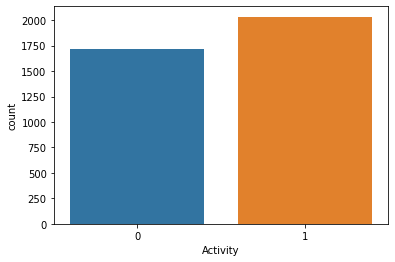

In [6]:
#проверим на сбалансированность классов
sns.countplot(data=data, x='Activity');

In [9]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Оптимизация гиперпараметров модели

посмотрим на метрики без оптимизации гиперпараметров

In [14]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.89
Test: 0.78


In [12]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


## Базовая оптимизация

### **GridSearchCV**

**ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ**

In [16]:
#вызываем класс GridSearchCV и обучаем модель логистической регрессии
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

CPU times: user 17.2 s, sys: 1.55 s, total: 18.8 s
Wall time: 2min 8s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


Метрика не улучшилась. Попробуем изменить параметры

In [17]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

CPU times: user 1.18 s, sys: 366 ms, total: 1.55 s
Wall time: 12min 52s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Немного улучшилась метрика но обучение заняло 12 минут! 

**СЛУЧАЙНЫЙ ЛЕС**

In [19]:
#попробуем использовать GridSearchCV и модель случайный лес
param_grid = {'n_estimators': list(range(100, 200, 10)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 3.25 s, sys: 360 ms, total: 3.61 s
Wall time: 2min 9s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Метрика немного улучшилась.

### **RandomizedSearchCV**

**ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ**

In [20]:
# используем RandomizedSearchCV и обучаем модель логистической регрессии
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

CPU times: user 14.6 s, sys: 295 ms, total: 14.9 s
Wall time: 3min 17s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}


Метрика не улучшилась по сравнению с GridSearchCV, но RandomizedSearch занял в 4 раза меньше времени! 

**СЛУЧАЙНЫЙ ЛЕС**

In [23]:
#используем оптимизацию RandomizedSearch и модель случайный лес
param_distributions = {'n_estimators': list(range(100, 200, 10)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions,
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 2.19 s, sys: 243 ms, total: 2.44 s
Wall time: 51.2 s
f1_score на обучающем наборе: 0.95
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 35}


Метрика улучшилась по сравнению с GridSearchCV и обучение заняло в два раза меньше времени.

## Продвинутая оптимизация

### **Hyperopt**

**ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ**

In [ ]:
print("Версия Hyperopt : {}".format(hyperopt.__version__))

In [62]:
#используем оптимизацию Hyperopt и обучаем модель логистической регрессии
# зададим пространство поиска гиперпараметров

space={'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))}
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params={'C': (params['C'])}
    #params = {'penalty': (params['penalty']), 
              #'solver': (params['solver'])
              #}
  
    # используем эту комбинацию для построения модели
    
    model = linear_model.LogisticRegression(
           **params, 
           random_state=random_state, max_iter=15000) #выставляю такое большое кол-во итераций, тк в дальнейшем функция кидает ошибку, что итерацй недостаточно

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

Начинаем подбор гиперпараметров.
P.S. До приведенного ниже и выше итогового кода я перебрала очень много вариантов параметров и также вариантов кол-ва итераций. Hyperopt подыскивал параметры по 40 минут. Я остановилась на одном варианте - только параметр C, тк уже отчаялась. Плюс ко всему, Hyperopt выдавал best параметров solver и penalty не строковым значением, а 0 или 1. Я не смогла найти объяснение такого поведения в интернете. Было бы классно, если бы примеры Hyperopt + Logistic regression были приведены в уроке

In [64]:
%%time 

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 10/10 [05:16<00:00, 31.64s/trial, best loss: -0.7828717496255433]
Наилучшие значения гиперпараметров {'C': 0.025314586529575047}
CPU times: user 6min 24s, sys: 33.4 s, total: 6min 57s
Wall time: 5min 16s


In [65]:
# рассчитаем точность для тестовой выборки

model = linear_model.LogisticRegression(
    random_state=random_state, 
    C=0.025314586529575047
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.80


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Значение метрики ухудшилось по сравнению с бейзлайном

**СЛУЧАЙНЫЙ ЛЕС**

In [48]:
#используем оптимизацию Hyperopt и модель случайный лес
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [49]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

подбираем гиперпараметры

In [52]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:53<00:00,  5.70s/trial, best loss: -0.8080577050312506]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: user 33.1 s, sys: 1.15 s, total: 34.2 s
Wall time: 1min 53s


In [54]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Метрику получилось улучшить по сравнение с бейзлайном, однако она хуже, чем на RandomizedSearch, да и времени больше заняла

### **OPTUNA**

**ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ**

In [75]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
                                                  
  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver, 
                                          random_state=random_state,
                                          max_iter=25000)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [76]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2022-10-07 21:30:20,218] A new study created in memory with name: LogisticRegression
[I 2022-10-07 21:30:24,174] Trial 0 finished with value: 0.88556606652426 and parameters: {'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.88556606652426.
[I 2022-10-07 21:30:45,841] Trial 1 finished with value: 1.0 and parameters: {'penalty': 'none', 'solver': 'lbfgs'}. Best is trial 1 with value: 1.0.
[I 2022-10-07 21:31:07,860] Trial 2 finished with value: 1.0 and parameters: {'penalty': 'none', 'solver': 'lbfgs'}. Best is trial 1 with value: 1.0.
[I 2022-10-07 21:35:40,882] Trial 3 finished with value: 0.9539594843462247 and parameters: {'penalty': 'none', 'solver': 'sag'}. Best is trial 1 with value: 1.0.
[I 2022-10-07 21:40:15,599] Trial 4 finished with value: 0.9539594843462247 and parameters: {'penalty': 'none', 'solver': 'sag'}. Best is trial 1 with value: 1.0.
[I 2022-10-07 21:40:37,271] Trial 5 finished with value: 1.0 and parameters: {'penalty': 'none', 'solver': 'lbfg

CPU times: user 15min 39s, sys: 39.5 s, total: 16min 18s
Wall time: 11min 23s


In [77]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs'}
f1_score на обучающем наборе: 1.00


In [79]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, max_iter=2500)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.72


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


На подбор параметров ушло 11 минут, а метрика заметно ухудшилась... Не уверена, что я все сделала правильно при создании пространства параметров.

**СЛУЧАЙНЫЙ ЛЕС**

In [66]:
#настроим оптимизацию гиперпараметров для алгоритма случайного леса.
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score


In [67]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-07 21:21:00,944] A new study created in memory with name: RandomForestClassifier
[I 2022-10-07 21:21:02,547] Trial 0 finished with value: 0.9277218664226898 and parameters: {'n_estimators': 121, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9277218664226898.
[I 2022-10-07 21:21:04,051] Trial 1 finished with value: 0.9141460433852735 and parameters: {'n_estimators': 129, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9277218664226898.
[I 2022-10-07 21:21:06,090] Trial 2 finished with value: 0.9075321494182486 and parameters: {'n_estimators': 173, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9277218664226898.
[I 2022-10-07 21:21:08,127] Trial 3 finished with value: 0.9447665547757095 and parameters: {'n_estimators': 153, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9447665547757095.
[I 2022-10-07 21:21:10,225] Trial 4 finished with value: 0.9340256566890653 and parameters: {'n_

CPU times: user 40.1 s, sys: 890 ms, total: 41 s
Wall time: 41.8 s


In [68]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [70]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


Есть улучшение метрики по сравнению с бейзлайном, потрачено времени меньше всего. 